In [1]:
import numpy as np
import scipy as sp
from scipy.sparse import save_npz, load_npz
from scipy.stats import describe
import math
import copy
np.set_printoptions(suppress=True)

In [2]:
V = load_npz("../CEMBA171212_4B.filtered.tfidf.r11.n1.npz")

In [6]:
xfname = "../CEMBA171212_4B.filtered.tfidf.r11.n1.xgi"
with open(xfname) as xf:
    xgi_content = xf.readlines()
    # you may also want to remove whitespace characters like `\n` at the end of each line
xgi_content = [x.strip() for x in xgi_content]

yfname = "../CEMBA171212_4B.filtered.tfidf.r11.n1.ygi"
with open(yfname) as yf:
    ygi_content = yf.readlines()
    # you may also want to remove whitespace characters like `\n` at the end of each line
ygi_content = [y.strip() for y in ygi_content]

In [21]:
basis = np.loadtxt("../CEMBA171212_4B.filtered.tfidf.r11.n1.W.mx")
coef = np.loadtxt("../CEMBA171212_4B.filtered.tfidf.r11.n1.H.mx")
conn = np.loadtxt("../CEMBA171212_4B.sparse.filtered.sklearn.tfidf.r11.n50.C.mx")

In [23]:
conn

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [2]:
def read_files(npz, xgi, ygi, basis, coef, conn):
    """
    Read snATAC data in npz format. The matrix's shape is ### (bins) x ### (samples).
    Read in xgi and ygi
    Read in basis (W) and coefficient (H) matrix
    """
    V = load_npz(npz) # in csr format
    xfname = xgi
    with open(xfname) as xf:
        xgi_content = xf.readlines()
        # you may also want to remove whitespace characters like `\n` at the end of each line
    xgi_content = [x.strip() for x in xgi_content]    
    yfname = ygi
    with open(yfname) as yf:
        ygi_content = yf.readlines()
        # you may also want to remove whitespace characters like `\n` at the end of each line
    ygi_content = [y.strip() for y in ygi_content]
    """
    xgi_content = np.loadtxt(xgi, dtype=str)
    ygi_content = np.loadtxt(ygi, dtype=str)
    """
    basis = np.loadtxt(basis)
    coef = np.loadtxt(coef)
    rank = coef.shape[0]
    conn = np.loadtxt(conn)
    return {'V':V, 'xgi':xgi_content, 'ygi':ygi_content, 'basis':basis, 'coef':coef, 'rank':rank, 'conn':conn}

npz = "../CEMBA171212_4B.filtered.tfidf.r11.n1.npz"
xgi = "../CEMBA171212_4B.filtered.tfidf.r11.n1.xgi"
ygi = "../CEMBA171212_4B.filtered.tfidf.r11.n1.ygi"
basis = "../CEMBA171212_4B.filtered.tfidf.r11.n1.W.mx"
coef = "../CEMBA171212_4B.filtered.tfidf.r11.n1.H.mx"
conn = "../CEMBA171212_4B.sparse.filtered.sklearn.tfidf.r11.n50.C.mx"
inF = read_files(npz, xgi, ygi, basis, coef, conn)

In [3]:
V = inF['V']
xgi = inF['xgi']
ygi = inF['ygi']
W = inF['basis']
H = inF['coef']
rank = inF['rank']
C = inF['conn']

In [4]:
def norm_H(H):
        normH = H/H.sum(axis=0, keepdims=True)
        return normH

def norm_W(W):
        normW = W/W.sum(axis=1, keepdims=True)
        return normW
normW = norm_W(W)
normH = norm_H(H)

In [51]:
import statistics
np.median(normW)

0.02017038568146674

In [5]:
import copy
def def_cell_class(normH, contribute):
        """ extract feature from H with contributes cutoff"""
        print("=== extract feature from H with contribute cutoff ===")
        index = list(range(normH.shape[1]))
        colmax = np.amax(normH, axis=0)
        colsum = np.sum(normH, axis=0)
        contributes = colmax / colsum
        class0 = normH.argmax(axis=0)
        unclass = np.where(contributes < contribute)
        unclass = unclass[0]
        unclassN = len(unclass)
        unclassPct = unclassN/normH.shape[1]
        class1 = copy.deepcopy(class0)
        class1[unclass] = 100
        stat = np.column_stack((index,class0,class1,contributes))
        stat[:,[0,1,2]] = stat[:,[0,1,2]].astype(int)
        return {'class0':class0, 'class1':class1, 'contributes':contributes, 'unclass':unclass, 'pct':unclassPct, 'stat':stat}

o_cell_class = def_cell_class(normH, 0.2)

=== extract feature from H with contribute cutoff ===


In [98]:
o_cell_class['stat']

array([[   0.        ,    0.        ,    0.        ,    0.74384731],
       [   1.        ,   10.        ,   10.        ,    0.51728954],
       [   2.        ,    3.        ,    3.        ,    0.83683732],
       ...,
       [4905.        ,   10.        ,   10.        ,    0.93183932],
       [4906.        ,    0.        ,    0.        ,    0.88150214],
       [4907.        ,    3.        ,    3.        ,    0.95056129]])

In [6]:
def cal_cell_sparseness(normH):
        print("=== calculate sparseness for each cell ===")
        sparseness = np.sqrt(np.sum(normH**2, axis=0))
        rank = normH.shape[0]
        a = 1 / np.sqrt(rank)
        norm_sparse = (sparseness - a) / (1 - a)
        return norm_sparse
o_cell_sparseness = cal_cell_sparseness(normH)

=== calculate sparseness for each cell ===


In [85]:
o_cell_sparseness

array([0.62603422, 0.48240375, 0.78714258, ..., 0.78811355, 0.85055826,
       0.92393372])

In [62]:
#tmpmx = np.array(([1,0.85,0.05,0,0.75,0.05],[0,0.05,0.05,0.8,0.15,0.05],[0,0.05,0.05,0.1,0.05,0],[0,0.05,0.85,0.1,0.05,0.9]))
#tmpmx = np.array(([1,0.85,0.05,0,0.75,0],[0,0.05,0.05,0.8,0.15,0],[0,0.05,0.05,0.1,0.05,0],[0,0.05,0.85,0.1,0.05,1]))
tmpmx = np.array(([1,0,1,0,0,0],[0,1,0,0,1,0],[0,0,0,1,0,0],[0,0,0,0,0,1]))
#tmpmx = np.array(([0.25,0.25,0.25,0.25,0.25,0.25],[0.25,0.25,0.25,0.25,0.25,0.25],[0.25,0.25,0.25,0.25,0.25,0.25],[0.25,0.25,0.25,0.25,0.25,0.25]))
#tmpmx = np.array(([0.5,0.5,0.5,0.5,0.5,0.5],[0.5,0.5,0.5,0.5,0.5,0.5]))
#tmpmx = np.array(([0,1,0,1,0,1],[1,0,1,0,1,0]))
print(tmpmx)
print(tmpmx.shape)
k = tmpmx.shape[0]
n = tmpmx.shape[1]

e_list = []
for i in range(n):
    h_ij_list = []
    for j in range(k):
        h_ij = tmpmx[j,i]
        if h_ij != 0:
            tmp = h_ij * math.log(h_ij, 2)
        else:
            tmp = 0
        h_ij_list.append(tmp)
    h_ij_sum = -np.sum(h_ij_list)
    e_list.append(h_ij_sum)

e = 1 - np.sum(e_list)/(n * math.log(k,2)) 
print(h_ij_list)
print(e_list)
print(e)
math.log(k,2)

[[1 0 1 0 0 0]
 [0 1 0 0 1 0]
 [0 0 0 1 0 0]
 [0 0 0 0 0 1]]
(4, 6)
[0, 0, 0, 0.0]
[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0]
1.0


2.0

In [7]:
def cal_entropy(normH):
        k = normH.shape[0]
        n = normH.shape[1]
        e_list = []
        for i in range(n):
                h_ij_list = []
                for j in range(k):
                        h_ij = normH[j,i]
                        if h_ij != 0:
                                tmp = h_ij * math.log(h_ij, 2)
                        else:
                                tmp = 0
                        h_ij_list.append(tmp)
                h_ij_sum = -np.sum(h_ij_list)
                e_list.append(h_ij_sum)
        normInfoGain = 1 - np.sum(e_list) / (n * math.log(k,2))
        return {'normInfoGain':normInfoGain, 'e_list':e_list}
o_entropy = cal_entropy(normH)

In [87]:
o_entropy['e_list']

[1.638792049440645,
 1.809967363357917,
 1.000743475317766,
 0.9760549469077295,
 2.4505412628954555,
 1.7510451859566272,
 1.2884151471923397,
 0.49042698904641674,
 2.185858859619388,
 1.269800206097045,
 1.8806862779932634,
 1.4831792562998096,
 1.0046156135297717,
 1.7941697492135995,
 1.8184355089368847,
 1.0513295289831768,
 2.374061070269385,
 0.8437491930215709,
 2.5876838221009657,
 0.4846629962442903,
 1.5068579557708908,
 0.09346101754479716,
 1.8208793796059775,
 0.6030133790372937,
 0.34194639597638476,
 2.1649969133457705,
 0.7923667192497506,
 1.034787871141732,
 1.6714205505193553,
 2.3673031015342736,
 2.3829327717104074,
 0.2846617321505074,
 0.4179642632791545,
 1.0747721610204852,
 1.4114182821481522,
 1.2565059165734154,
 0.9850930456299742,
 1.170532872016205,
 2.1390812241394737,
 1.1629478713261683,
 1.9525159248709592,
 0.5755576183503065,
 1.778243093524528,
 2.1270151772432606,
 0.010003341388552519,
 0.07549611705664891,
 2.260417959655366,
 1.09264370281756

In [8]:
np.set_printoptions(suppress=True)
def stat_H(o_cell_class, o_cell_sparseness, o_entropy, xgi, prefix):
        stat = o_cell_class['stat']
        norm_sparse = o_cell_sparseness
        entropy = o_entropy['e_list']
        statH = np.column_stack((stat,norm_sparse,entropy))
        statH[statH <= 0 ] = 0
        statH[:,[0,1,2]] = statH[:,[0,1,2]].astype(int)
        print(len(xgi))
        print(statH.shape)
        statH = np.column_stack((xgi,statH))
        head = "\t".join(["xgi", "index", "class0", "class1", "contributes", "sparseness", "entropy"])
        statH_fname = prefix + "." + "statH"
        np.savetxt(statH_fname, statH, fmt= "%s", delimiter="\t", header=head)
        return statH
o_stat_H = stat_H(o_cell_class, o_cell_sparseness, o_entropy, xgi, "../foo")

4908
(4908, 6)


In [93]:
o_stat_H

array([['AGCGATAGAACCAGGTAGGCGAAGAATGACGT', '0.0', '0.0', ...,
        '0.7104689150080489', '0.6260342220217332', '1.638792049440645'],
       ['AGCGATAGAACCAGGTAGGCGAAGATTCGTTG', '1.0', '10.0', ...,
        '0.5046539345159236', '0.48240374688824617', '1.809967363357917'],
       ['AGCGATAGAACCAGGTAGGCGAAGCGAATTCC', '2.0', '3.0', ...,
        '0.8380973140117259', '0.7871425821474269', '1.000743475317766'],
       ...,
       ['TCCGGAGATTAGCCTCCCTATCCTGAAGTATG', '4905.0', '10.0', ...,
        '0.8317211879154739', '0.7881135528382457', '0.794417011288032'],
       ['TCCGGAGATTCCATCCCAGGACGTAACGAACG', '4906.0', '0.0', ...,
        '0.8822553249830185', '0.8505582604387881', '0.5632497113540043'],
       ['TCCGGAGATTCCATCCCAGGACGTGGATACTA', '4907.0', '3.0', ...,
        '0.9429808605078532', '0.9239337177456873', '0.4093515576508714']],
      dtype='<U32')

In [9]:
def cal_featureScore_kim(W):
        """ extract feature from W """
        print("=== extract feature from W ===")
        k = W.shape[1]
        m = W.shape[0]
        fs_list = []
        for i in range(m):
                rowsum = np.sum(W[i,])
                p_iq_x_list = []
                for q in range(k):
                        p_iq = W[i,q] / rowsum
                        if p_iq != 0:
                                tmp = p_iq * math.log(p_iq,2)
                        else:
                                tmp = 0
                        p_iq_x_list.append(tmp)
                fs = 1 + 1/math.log(k,2) * np.sum(p_iq_x_list)
                fs_list.append(fs)
        med = np.median(fs_list)
        mad = np.median(np.absolute(fs_list - med))
        fs_cutoff = med + 3 * mad
        selt_fs_idx = np.concatenate(np.where(fs_list >= fs_cutoff))
        print(type(selt_fs_idx))
        """
        mad = robust.mad(fs_list)
        """
        return {'fs':fs_list, 'med': med, 'mad':mad, 'fs_cutoff': fs_cutoff, 'selt_fs_idx': selt_fs_idx}
o_featureScore_kim = cal_featureScore_kim(W)

=== extract feature from W ===
<class 'numpy.ndarray'>


In [277]:
o_featureScore_kim['selt_fs_idx']

array([    35,     90,     94, ..., 190144, 190159, 190163])

In [10]:
def def_region_class(normW):
        """ define class from W with median contribute as cutoff"""
        print("=== extract feature from H with median contribute as cutoff ===")
        rowmax = np.amax(normW, axis=1)
        rowsum = np.sum(normW, axis=1)
        contributes = rowmax / rowsum
        class0 = normW.argmax(axis=1)
        med_contribute = np.median(normW)
        selt_med_idx = np.concatenate(np.where(contributes > med_contribute))
        return {'class0':class0, 'contributes':contributes, 'med_contribute': med_contribute, 'selt_med_idx':selt_med_idx}
o_region_class = def_region_class(normW)

=== extract feature from H with median contribute as cutoff ===


In [269]:
from scipy.stats import describe
len(o_region_class['selt_med_idx'])

190187

In [11]:
def stat_W(o_region_class, o_featureScore_kim, ygi, prefix):
    m = o_region_class['class0'].shape[0]
    index = list(range(m))
    class0 = o_region_class['class0']
    contributes = o_region_class['contributes']
    fs = o_featureScore_kim['fs']

    selt_fs_list = np.array([0] * m)
    selt_fs_idx = o_featureScore_kim['selt_fs_idx']
    selt_fs_list[selt_fs_idx] = 1
    selt_med_list = np.array([0] * m)
    selt_med_idx = o_region_class['selt_med_idx']
    selt_med_list[selt_med_idx] = 1
    
    statW = np.column_stack((index, class0, contributes, fs, selt_fs_list, selt_med_list))
    head="\t".join(["chr", "start", "end", "index", "class0", "contributes", "fs", "selt_fs_list", "selt_med_list"])
    statW_fname = prefix + "." + "statW"
    statW[:,[0,1,4,5]] = statW[:,[0,1,4,5]].astype(int)
    statW = np.column_stack((ygi, statW))
    np.savetxt(statW_fname, statW, fmt= "%s", delimiter="\t", header=head)
    return statW

o_stat_W = stat_W(o_region_class, o_featureScore_kim, ygi, "../foo")

In [12]:
o_stat_W

array([['chr1\t3012401\t3013400', '0.0', '8.0', ...,
        '0.3520752452629984', '0.0', '1.0'],
       ['chr1\t3094873\t3095872', '1.0', '13.0', ...,
        '0.3137348602191956', '0.0', '1.0'],
       ['chr1\t3113428\t3114427', '2.0', '10.0', ...,
        '0.27460794115922216', '0.0', '1.0'],
       ...,
       ['chrY\t90810635\t90811634', '190184.0', '5.0', ...,
        '0.0860556638632376', '0.0', '1.0'],
       ['chrY\t90812539\t90813538', '190185.0', '5.0', ...,
        '0.1470057562550945', '0.0', '1.0'],
       ['chrY\t90828575\t90829574', '190186.0', '7.0', ...,
        '0.2589903122912919', '0.0', '1.0']], dtype='<U32')

In [12]:
def gerenate_files(o_stat_H, o_stat_W, rank, V, prefix):
    for r in range(rank):
        print(r)
        n = r + 1
        idx = np.concatenate(np.where(o_stat_H[:,2].astype(float).astype(int) == r))
        selt_xgi = o_stat_H[idx,0]
        selt_V = V[:,idx]
        xgi_fname = prefix + "." + "metacell_" + str(n) + "." + "xgi"
        V_fname = prefix + "." + "metacell_" + str(n) + "." + "npz"
        np.savetxt(xgi_fname, selt_xgi, fmt= "%s", delimiter="\t")
        save_npz(V_fname, selt_V)
        
        idx2 = np.concatenate(np.where((o_stat_W[:,2].astype(float).astype(int) == r) 
                                       & (o_stat_W[:,5].astype(float).astype(int) == 1) 
                                       & (o_stat_W[:,6].astype(float).astype(int) == 1)))
        selt_feature = o_stat_W[idx2,0]
        feature_fname = prefix + "." + "metacell_" + str(n) + "." + "feature"
        np.savetxt(feature_fname, selt_feature, fmt= "%s", delimiter="\t")
        
gerenate_files(o_stat_H, o_stat_W, rank, V, "../foo1")

0
1
2
3
4
5
6
7
8
9
10


### silhouette analysis

In [41]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [129]:
X = normH.T

In [122]:
metaCell_labels = o_stat_H[:,2].astype(float).astype(int)
silhouette_avg = silhouette_score(X, metaCell_labels)
sample_silhouette_values = silhouette_samples(X, metaCell_labels)
print(silhouette_avg)
print(sample_silhouette_values)

0.5548304985899056
[0.64119492 0.17198999 0.6965642  ... 0.78157472 0.65740545 0.6572791 ]


In [16]:
from sklearn.metrics import pairwise_distances
o_pairwise_distances = pairwise_distances(X)
o_pairwise_distances.shape

(4908, 4908)

In [42]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def cal_silhouette(normH,o_stat_H):
        X = normH.T
        n_clusters = normH.shape[0]
        cluster_labels = o_stat_H[:,2].astype(float).astype(int)
        """
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        """
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)
        """# Compute the silhouette scores for each sample"""
        sample_silhouette_values = silhouette_samples(X, cluster_labels)
        return {'silhouette':silhouette_avg, 'silhouette_values':sample_silhouette_values}

def cal_nmds(X):
        embedding = MDS(n_components=2, dissimilarity='precomputed', n_jobs=2, verbose=2)
        X_transformed = embedding.fit_transform(X)
        return X_transformed

def cal_pairwise_dist(normH):
        X = normH.T
        X_pairwise_dist = pairwise_distances(X)
        return X_pairwise_dist

def cal_pairwise_pearson(normH):
        X = normH.T
        X_corrcoef = np.corrcoef(X)
        X_corrcoef_dist = np.sqrt(2*(1-X_corrcoef))
        return X_corrcoef_dist

def cal_tSNE(X_dist, p):
        X_transformed = TSNE(n_components=2, perplexity=p, random_state=1, verbose=2, metric="precomputed").fit_transform(X_dist)
        return X_transformed

In [43]:
def plot_silhouette_tsne(o_silhouette, X_transformed, o_stat_H, rank, prefix):
        n_clusters = rank
        print(n_clusters)
        silhouette_avg = o_silhouette['silhouette']
        sample_silhouette_values = o_silhouette['silhouette_values']
        cluster_labels = o_stat_H[:,2].astype(float).astype(int)

        """# Create a subplot with 1 row and 2 columns"""
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)
        fig.set_dpi(300)
        """
        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        """
        ax1.set_xlim([-0.1, 1])
        """
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        """
        ax1.set_ylim([0, len(X_transformed) + (n_clusters + 1) * 10])

        y_lower = 10
        for i in range(n_clusters):
                """# Aggregate the silhouette scores for samples belonging to cluster i, and sort them """
                ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
                ith_cluster_silhouette_values.sort()
                size_cluster_i = ith_cluster_silhouette_values.shape[0]
                y_upper = y_lower + size_cluster_i
                color = cm.nipy_spectral(float(i) / n_clusters)
                ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)
                """# Label the silhouette plots with their cluster numbers at the middle"""
                ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
                """# Compute the new y_lower for next plot"""
                y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel(" ".join(["The silhouette coefficient values (mean:",str(silhouette_avg),")"]))
        ax1.set_ylabel("Cluster label")

        """# The vertical line for average silhouette score of all the values """
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        """# 2nd Plot showing the actual clusters formed"""
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X_transformed[:, 0], X_transformed[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')
        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st tsne")
        ax2.set_ylabel("Feature space for the 2nd tsne")
        plt.suptitle(("Silhouette analysis for tSNE clustering on coefficient matrix H "
                "with n_clusters = %d" % n_clusters),fontsize=14, fontweight='bold')
        fig.savefig('.'.join([prefix, "silhouette_tsne", "png"]))

In [18]:
o_silhouette = cal_silhouette(normH,o_stat_H)
X_dist = cal_pairwise_pearson(normH)
X_transformed = cal_tSNE(X_dist, 50)

For n_clusters = 11 The average silhouette_score is : 0.5548304985899056
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 4908 samples in 0.030s...
[t-SNE] Computed neighbors for 4908 samples in 1.505s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4908
[t-SNE] Computed conditional probabilities for sample 2000 / 4908
[t-SNE] Computed conditional probabilities for sample 3000 / 4908
[t-SNE] Computed conditional probabilities for sample 4000 / 4908
[t-SNE] Computed conditional probabilities for sample 4908 / 4908
[t-SNE] Mean sigma: 0.000134
[t-SNE] Computed conditional probabilities in 1.358s
[t-SNE] Iteration 50: error = 74.9598618, gradient norm = 0.0496393 (50 iterations in 10.980s)
[t-SNE] Iteration 100: error = 63.0186882, gradient norm = 0.0095163 (50 iterations in 8.619s)
[t-SNE] Iteration 150: error = 60.9362640, gradient norm = 0.0051873 (50 iterations in 8.127s)
[t-SNE] Iteration 200: error = 60.0655670, gradient norm = 0.0030288 (50 iterations in 8

In [28]:
plot_silhouette_tsne(o_silhouette, X_transformed, o_stat_H, rank, "../foo1")

11


In [154]:
X_corrcoef = np.corrcoef(X)
X_corrcoef_dist = np.sqrt(2*(1-X_corrcoef))
X_corrcoef_dist.shape

(4908, 4908)

In [155]:
from sklearn.manifold import TSNE

X = normH.T
n_clusters = normH.shape[0]

from sklearn.metrics import pairwise_distances
X_pairwise_distances = pairwise_distances(X)
X_pairwise_distances.shape

X_corrcoef = np.corrcoef(X)
X_corrcoef_dist = np.sqrt(2*(1-X_corrcoef))
X_corrcoef_dist.shape

#X_embedded = TSNE(n_components=2, perplexity=40, verbose=2, metric="precomputed").fit_transform(X_pairwise_distances)
X_embedded = TSNE(n_components=2, perplexity=40, verbose=2, metric="precomputed").fit_transform(X_corrcoef_dist)
#X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 4908
[t-SNE] Computed conditional probabilities for sample 2000 / 4908
[t-SNE] Computed conditional probabilities for sample 3000 / 4908
[t-SNE] Computed conditional probabilities for sample 4000 / 4908
[t-SNE] Computed conditional probabilities for sample 4908 / 4908
[t-SNE] Mean sigma: 0.000000
[t-SNE] Iteration 25: error = 1.6914784, gradient norm = 0.0104722
[t-SNE] Iteration 50: error = 1.6091480, gradient norm = 0.0067008
[t-SNE] Iteration 75: error = 1.2874182, gradient norm = 0.0026859
[t-SNE] Iteration 100: error = 1.2182215, gradient norm = 0.0022707
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.218222
[t-SNE] Iteration 125: error = 1.1023322, gradient norm = 0.0017774
[t-SNE] Iteration 150: error = 1.0660053, gradient norm = 0.0017507
[t-SNE] Iteration 175: error = 1.0571234, gradient norm = 0.0016915
[t-SNE] Iteration 200: error = 1.0531235, gradie

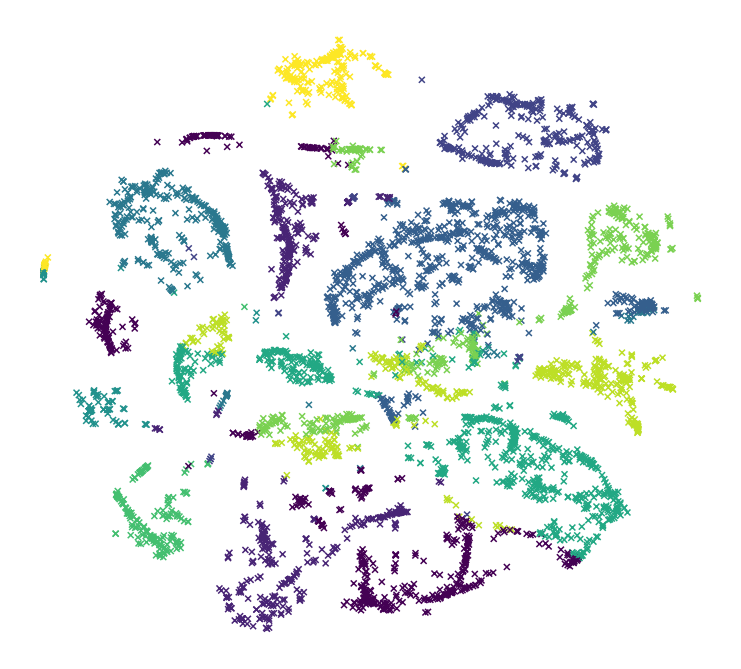

In [174]:
metaCell_labels = o_stat_H[:,2].astype(float).astype(int)

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(frameon=False)
plt.setp(ax, xticks=(), yticks=())
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9,
                wspace=0.0, hspace=0.0)
for i in range(n_clusters):
    color = cm.nipy_spectral(float(i) / n_clusters)

plt.scatter(X_embedded[:, 0], X_embedded[:, 1],
        c=metaCell_labels, marker='x', label='tSNE')

plt.show()

In [20]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

X = normH.T
n_clusters = normH.shape[0]

from sklearn.metrics import pairwise_distances
X_pairwise_distances = pairwise_distances(X)
X_pairwise_distances.shape

X_corrcoef = np.corrcoef(X)
X_corrcoef_dist = np.sqrt(2*(1-X_corrcoef))
X_corrcoef_dist.shape

embedding = MDS(n_components=2, dissimilarity='precomputed', n_jobs=4, verbose=2)
X_transformed = embedding.fit_transform(X_pairwise_distances)
X_transformed.shape

it: 0, stress 3964066.09082538
it: 0, stress 3978055.4055223
it: 0, stress 3967456.4726676797
it: 0, stress 3964405.1800223305
it: 1, stress 2735575.6606825576
it: 1, stress 2718789.7869793256
it: 1, stress 2717307.293025772
it: 1, stress 2720453.757564829
it: 2, stress 2486702.1934765545
it: 2, stress 2476472.004213427
it: 2, stress 2476800.6063067927
it: 2, stress 2480959.640336209
it: 3, stress 2320389.3757251096
it: 3, stress 2318754.9603089844
it: 3, stress 2324677.507709502
it: 3, stress 2323795.6161968946
it: 4, stress 2222682.625236965
it: 4, stress 2225860.2443610504
it: 4, stress 2220871.748411563
it: 4, stress 2225090.085325338
it: 5, stress 2162257.0485447533
it: 5, stress 2164483.3840661105
it: 5, stress 2166774.9872082174
it: 5, stress 2162069.9729316225
it: 6, stress 2126845.105303032
it: 6, stress 2126334.515339363
it: 6, stress 2131046.1967052044
it: 6, stress 2126912.4754857146
it: 7, stress 2103757.5813422985
it: 7, stress 2105078.6767414114
it: 8, stress 2089610.898

it: 61, stress 1363153.7536022794
it: 62, stress 1387500.9466439635
it: 64, stress 1362352.414032397
it: 62, stress 1353437.7273436433
it: 58, stress 1429557.3702392061
it: 63, stress 1375619.2950306064
it: 65, stress 1351253.6411905233
it: 63, stress 1343550.52800681
it: 59, stress 1420065.6948448056
it: 64, stress 1364241.011246968
it: 66, stress 1341018.185268939
it: 60, stress 1411017.204695966
it: 65, stress 1353288.6511984854
it: 64, stress 1333515.9167101502
it: 67, stress 1331585.746051205
it: 66, stress 1342701.679648606
it: 61, stress 1402522.4463601941
it: 65, stress 1323534.7507638182
it: 68, stress 1322858.7886388518
it: 62, stress 1394591.700063347
it: 67, stress 1332442.808993409
it: 66, stress 1313526.7174946298
it: 69, stress 1314735.1643996332
it: 63, stress 1387217.9600786315
it: 68, stress 1322394.5534937435
it: 67, stress 1303458.102093223
it: 64, stress 1380328.225276467
it: 70, stress 1307068.4807627606
it: 69, stress 1312327.4188846787
it: 65, stress 1373662.923

it: 121, stress 1160379.5570234044
it: 124, stress 1218326.710727092
it: 120, stress 1203816.5696581004
it: 121, stress 1181017.3868222416
it: 125, stress 1218104.741356631
it: 122, stress 1159352.663233164
it: 121, stress 1202752.281987902
it: 126, stress 1217898.600326022
it: 123, stress 1158297.6789671604
it: 122, stress 1180678.0115185825
it: 122, stress 1201649.5939550686
it: 127, stress 1217706.537399371
it: 124, stress 1157191.9399493549
it: 123, stress 1200498.7035168104
it: 123, stress 1180346.6598048669
it: 128, stress 1217526.6999691895
it: 124, stress 1199311.0253281423
it: 124, stress 1180024.6443162842
it: 125, stress 1155998.4207718656
it: 125, stress 1179715.56783483
it: 129, stress 1217357.3759185206
it: 126, stress 1154692.5494463153
it: 125, stress 1198094.091386578
it: 126, stress 1179420.130875064
it: 127, stress 1153255.9329335256
it: 130, stress 1217198.2973175007
it: 126, stress 1196865.4902495085
it: 128, stress 1151662.3030643356
it: 127, stress 1179134.967825

it: 179, stress 1105781.3687920137
it: 180, stress 1171580.670744127
it: 182, stress 1209745.2885986269
it: 180, stress 1105603.3802480472
it: 181, stress 1108988.9601169864
it: 181, stress 1171461.037586843
it: 181, stress 1105404.2426113323
it: 183, stress 1209648.5397751024
it: 182, stress 1108711.9370050586
it: 182, stress 1171309.53720919
it: 183, stress 1108456.5341613346
it: 182, stress 1105167.1970648903
it: 184, stress 1209552.9448197347
it: 183, stress 1171136.3303250666
it: 183, stress 1104919.4097298824
it: 184, stress 1108213.367798711
it: 185, stress 1209450.1852399178
it: 184, stress 1104667.160711375
it: 185, stress 1107957.243097225
it: 184, stress 1170961.8429021537
it: 186, stress 1209353.7990854923
it: 186, stress 1107670.4384852943
it: 185, stress 1104406.7186746718
it: 185, stress 1170793.1340348679
it: 187, stress 1209271.8678371473
it: 187, stress 1107400.374190548
it: 186, stress 1104139.1399230605
it: 186, stress 1170628.0024337608
it: 188, stress 1209202.1514

it: 234, stress 1166384.2807168562
it: 239, stress 1197509.046853412
it: 242, stress 1094654.4661870664
it: 243, stress 1101918.611645402
it: 235, stress 1166328.075075605
it: 240, stress 1196277.2352864926
it: 236, stress 1166262.019385708
it: 243, stress 1094611.953069019
it: 244, stress 1101847.3372184697
it: 244, stress 1094574.8966798123
it: 237, stress 1166183.4619891695
it: 241, stress 1194862.4726456802
it: 245, stress 1101767.9629719916
it: 238, stress 1166095.5062334053
it: 242, stress 1193263.0664823179
it: 245, stress 1094542.5384720329
it: 246, stress 1101682.507508918
it: 239, stress 1166003.720014787
it: 246, stress 1094513.9709559907
it: 243, stress 1191493.2720722258
it: 247, stress 1101592.3447882289
it: 247, stress 1094488.31176643
it: 240, stress 1165913.5000638636
it: 248, stress 1094464.6944819174
it: 248, stress 1101496.826104037
it: 244, stress 1189583.9257939614
it: 241, stress 1165827.1744724174
it: 249, stress 1094442.4890320671
it: 249, stress 1101396.000937

[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed: 17.9min remaining: 17.9min


it: 289, stress 1160891.1212885897
it: 296, stress 1160926.8314342329
it: 297, stress 1160898.6246050359
it: 290, stress 1160719.5599443722
it: 298, stress 1160869.0327710558
it: 291, stress 1160586.636113875
it: 299, stress 1160838.6940399462
it: 292, stress 1160482.784586256
it: 293, stress 1160400.7135524063
it: 294, stress 1160333.706021729
it: 295, stress 1160277.6173468058
it: 296, stress 1160229.7154271358
it: 297, stress 1160187.1077245579
it: 298, stress 1160148.2185854905
it: 299, stress 1160111.6875452143


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 18.3min finished


(4908, 2)

In [45]:
#statH = np.loadtxt("../foo.statH", dtype={'formats':('S32', np.float, np.float, np.float, np.float, np.float, np.float)})
#statH = np.genfromtxt("../foo.statH", names = True, dtype=('S32', np.float, np.float, np.float, np.float, np.float, np.float))
statH = np.genfromtxt("../foo.statH", dtype=None, names=True)
statH.shape

/mnt/silencer2/home/yangli/apps/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  This is separate from the ipykernel package so we can avoid doing imports until


(4908,)

In [115]:
rank = np.max(statH['class0']).astype(int) + 1
qnames = list(statH[np.where(statH['class0']==0)]['xgi'].astype(str))
#qnames = ["AGCGATAGAACCAGGTAGGCGAAGAATGACGT", "AGCGATAGAACCAGGTCAGGACGTGAAGTATG","AGCGATAGAACCAGGTCAGGACGTTTGGAAGT"]
qnames_set = set(qnames)
import pysam
bamf = pysam.AlignmentFile("../00.data/CEMBA171212_4B/tmp.repl1_CEMBA171212_4B.sorted.bam")
#bamf = pysam.AlignmentFile("../foo.sam", "r")
obam = pysam.AlignmentFile("../fooo.bam", "wb", template=bamf)
for b in bamf.fetch(until_eof=True):
    if b.query_name.split(':')[0] in qnames_set:
        obam.write(b)
obam.close()
bamf.close()

In [125]:
#qnames = list(statH[np.where(statH['class0']==2)]['xgi'].astype(str))
qnames = list(statH[statH['class0']==3]['xgi'].astype(str))
#qnames = ["AGCGATAGAACCAGGTAGGCGAAGAATGACGT", "AGCGATAGAACCAGGTCAGGACGTGAAGTATG", "AGCGATAGAACCAGGTCAGGACGTTTGGAAGT","AGCGATAGAACCAGGTTATAGCCTGAAGTATG","AGCGATAGAAGCAACGATAGAGGCTTCATCCA"]
len(qnames)

828

In [83]:
?pysam.AlignmentFile

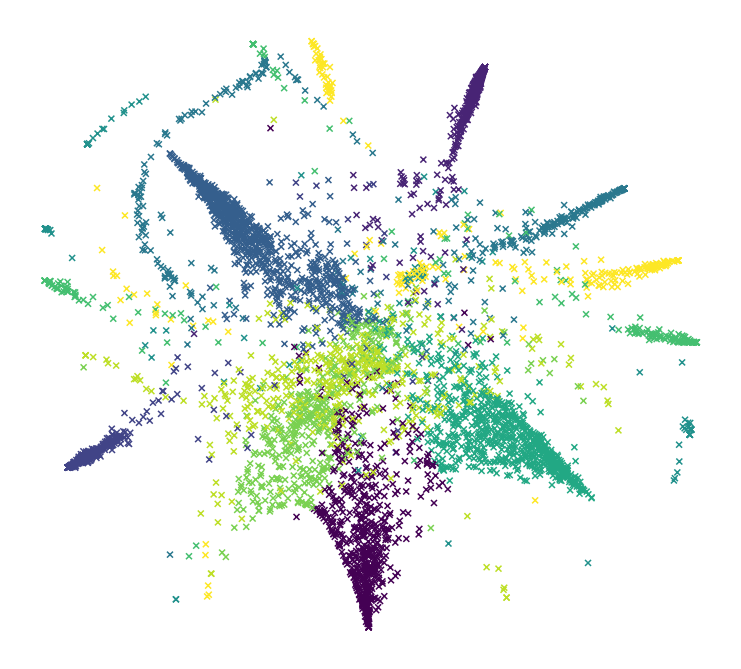

In [21]:
metaCell_labels = o_stat_H[:,2].astype(float).astype(int)

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(frameon=False)
plt.setp(ax, xticks=(), yticks=())
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9,
                wspace=0.0, hspace=0.0)

plt.scatter(X_transformed[:, 0], X_transformed[:, 1],
        c=metaCell_labels, marker='x', label='NMDS')

plt.show()